In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Set random seed to ensure reproducible runs
RSEED = 50

In [12]:
df = pd.read_csv('C:\\01-FaculdadeSemestreAtual\\Aprendizagem_de_Maquina\\bases\\2015.csv').sample(100000, random_state = RSEED)
df.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENUM,...,_PAREC1,_PASTAE1,_LMTACT1,_LMTWRK1,_LMTSCL1,_RFSEAT2,_RFSEAT3,_FLSHOT6,_PNEUMO2,_AIDTST3
383119,49.0,4.0,b'05192015',b'05',b'19',b'2015',1100.0,2.015009e+09,2.015009e+09,NaN,...,4.0,2.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0
55536,9.0,9.0,b'09232015',b'09',b'23',b'2015',1100.0,2.015005e+09,2.015005e+09,1.0,...,2.0,2.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0
267093,34.0,10.0,b'11052015',b'11',b'05',b'2015',1100.0,2.015011e+09,2.015011e+09,NaN,...,4.0,2.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0
319092,41.0,4.0,b'04062015',b'04',b'06',b'2015',1100.0,2.015002e+09,2.015002e+09,1.0,...,2.0,2.0,2.0,2.0,3.0,1.0,1.0,2.0,1.0,2.0
420978,54.0,5.0,b'05112015',b'05',b'11',b'2015',1100.0,2.015004e+09,2.015004e+09,NaN,...,1.0,1.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0


In [13]:
df = df.select_dtypes('number')
df['_RFHLTH'] = df['_RFHLTH'].replace({2: 0})
df = df.loc[df['_RFHLTH'].isin([0, 1])].copy()
df = df.rename(columns = {'_RFHLTH': 'label'})
df['label'].value_counts()

label
1.0    81140
0.0    18579
Name: count, dtype: int64

In [14]:
# Remove columns with missing values
df = df.drop(columns = ['POORHLTH', 'PHYSHLTH', 'GENHLTH', 'PAINACT2', 
                        'QLMENTL2', 'QLSTRES2', 'QLHLTH2', 'HLTHPLN1', 'MENTHLTH'])

In [15]:
from sklearn.model_selection import train_test_split

# Extract the labels
labels = np.array(df.pop('label'))

# 30% examples in test data
train, test, train_labels, test_labels = train_test_split(df, labels, 
                                                          stratify = labels,
                                                          test_size = 0.3, 
                                                          random_state = RSEED)

In [16]:
train = train.fillna(train.mean())
test = test.fillna(test.mean())

# Features for feature importances
features = list(train.columns)

In [17]:
train.shape

(69803, 313)

In [18]:
test.shape

(29916, 313)

In [19]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=RSEED)

# Train tree
tree.fit(train, train_labels)
print(f'Decision tree has {tree.tree_.node_count} nodes with maximum depth {tree.tree_.max_depth}.')

Decision tree has 12327 nodes with maximum depth 55.


In [20]:
# Make probability predictions
train_probs = tree.predict_proba(train)[:, 1]
probs = tree.predict_proba(test)[:, 1]

train_predictions = tree.predict(train)
predictions = tree.predict(test)

In [21]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

print(f'Train ROC AUC Score: {roc_auc_score(train_labels, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(test_labels, probs)}')

Train ROC AUC Score: 1.0
Test ROC AUC  Score: 0.6639639045644772


In [22]:
print(f'Baseline ROC AUC: {roc_auc_score(test_labels, [1 for _ in range(len(test_labels))])}')

Baseline ROC AUC: 0.5


In [23]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

Recall Baseline: 1.0 Test: 0.83 Train: 1.0
Precision Baseline: 0.81 Test: 0.88 Train: 1.0
Roc Baseline: 0.5 Test: 0.66 Train: 1.0


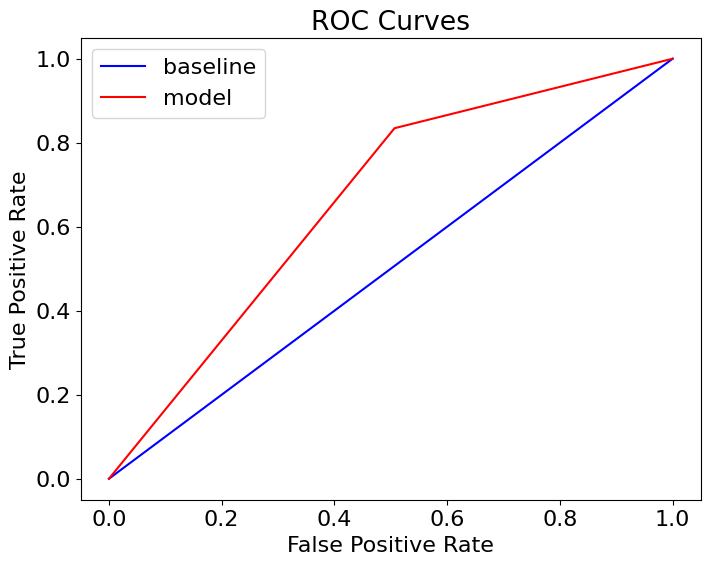

In [24]:
evaluate_model(predictions, probs, train_predictions, train_probs)

# Matriz de Confusão

In [25]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[ 2750  2824]
 [ 4027 20315]]


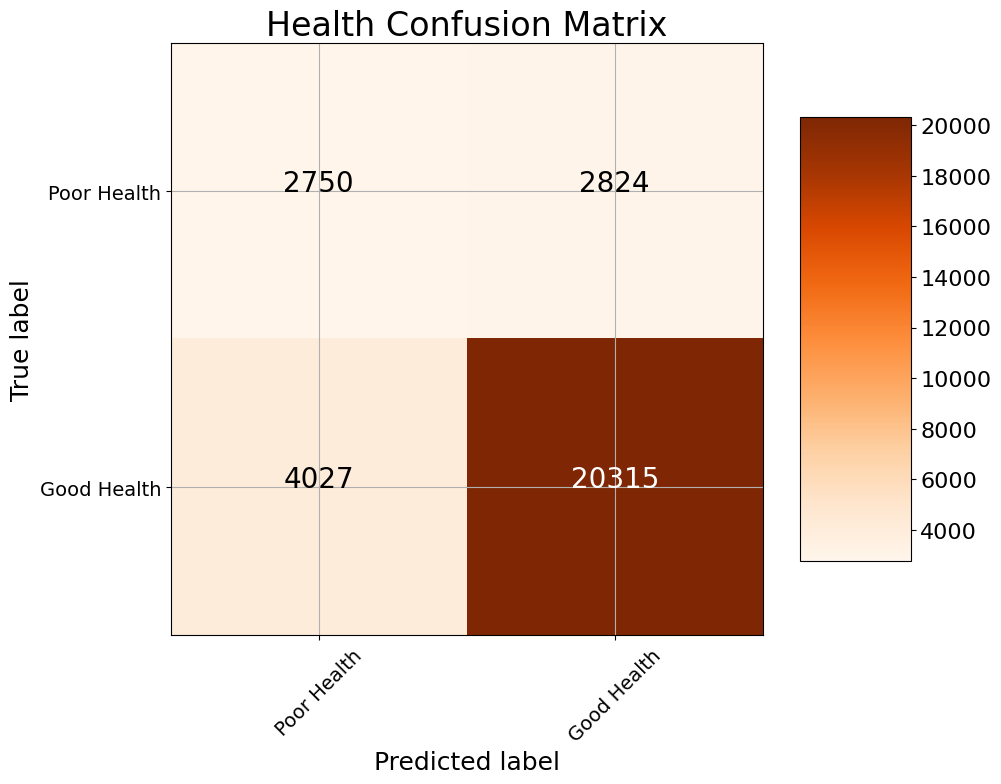

In [26]:
cm = confusion_matrix(test_labels, predictions)
plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
                      title = 'Health Confusion Matrix')

In [27]:
fi = pd.DataFrame({'feature': features,
                   'importance': tree.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.head()

,feature,importance
62,DIFFWALK,0.191702
58,QLACTLM2,0.030550
51,EMPLOY1,0.023743
64,DIFFALON,0.018419
245,_BMI5,0.016785


# Floresta Aleatória

In [28]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

# Fit on training data
model.fit(train, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished


RandomForestClassifier(n_jobs=-1, random_state=50, verbose=1)

In [29]:
n_nodes = []
max_depths = []

for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 13396
Average maximum depth 46


In [30]:
train_rf_predictions = model.predict(train)
train_rf_probs = model.predict_proba(train)[:, 1]

rf_predictions = model.predict(test)
rf_probs = model.predict_proba(test)[:, 1]

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


Recall Baseline: 1.0 Test: 0.96 Train: 1.0
Precision Baseline: 0.81 Test: 0.88 Train: 1.0
Roc Baseline: 0.5 Test: 0.87 Train: 1.0


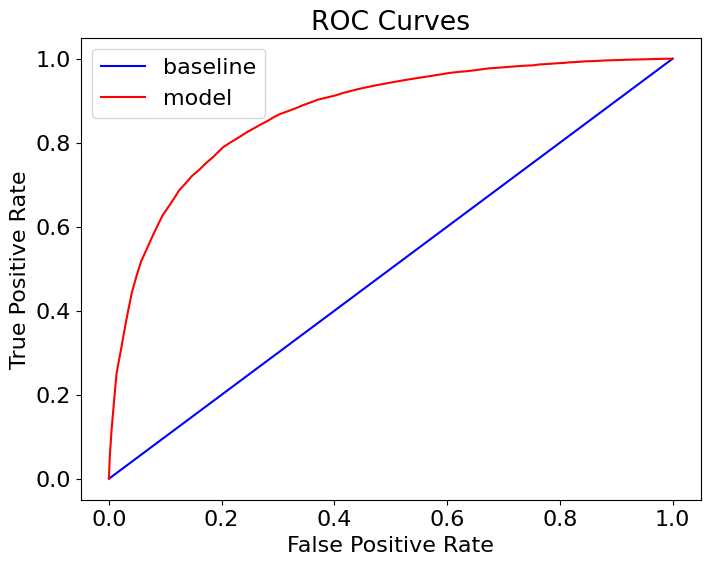

In [31]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

Confusion matrix, without normalization
[[ 2438  3136]
 [ 1043 23299]]


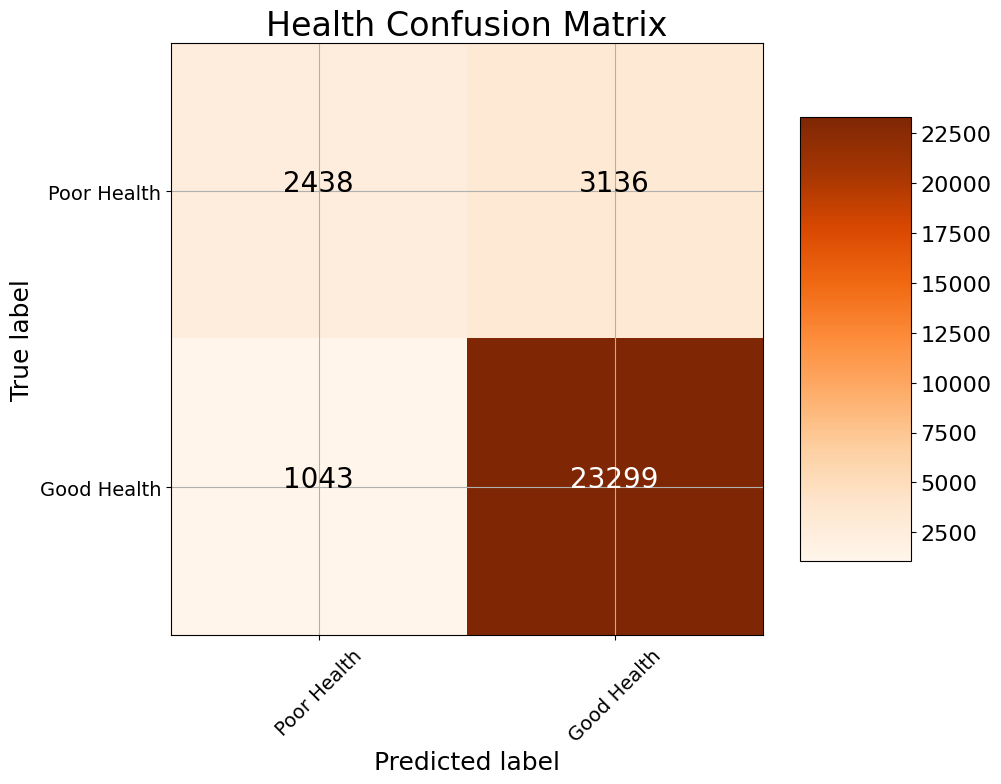

In [32]:
cm = confusion_matrix(test_labels, rf_predictions)
plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
                      title = 'Health Confusion Matrix')

In [33]:
fi_model = pd.DataFrame({'feature': features,
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi_model.head(10)

,feature,importance
62,DIFFWALK,0.036200
58,QLACTLM2,0.030694
51,EMPLOY1,0.024156
64,DIFFALON,0.022699
59,USEEQUIP,0.016922
61,DECIDE,0.016271
307,_LMTSCL1,0.013424
53,INCOME2,0.011929
37,CHCCOPD1,0.011506
245,_BMI5,0.011497


In [34]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = RSEED)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 1, random_state=RSEED)

# Fit 
rs.fit(train, train_labels)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\01-FaculdadeSemestreAtual\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
9 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "c:\01-FaculdadeSemestreAtual\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\01-FaculdadeSemestreAtual\.venv\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\01-FaculdadeSemestreAtual\.venv\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\01

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=50),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, np.int64(3),
                                                      np.int64(3), np.int64(3),
                                                      np.int64(4), np.int64(4),
                                                      np.int64(4), np.int64(5),
                                                      np.int64(5), np.int64(5),
                                                      np.int64(6), np.int64(6),
                                                      np.int64(6), np.int64(7),
                                                      np.int64(7), np.int64(7),
                                                      np.int64(8), np.int64(8...
                                                           np.int64(11),
                                                           np.int64(11),
                                                           np.int64(12),
                                                           np.int64(12),
                                                           np.int64(12),
                                                           np.int64(12), ...],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': array([ 10,  13,  17,  21,  25,  29,  33,  37,  41,  44,  48,  52,  56,
        60,  64,  68,  72,  75,  79,  83,  87,  91,  95,  99, 103, 106,
       110, 114, 118, 122, 126, 130, 134, 137, 141, 145, 149, 153, 157,
       161, 165, 168, 172, 176, 180, 184, 188, 192, 196, 200])},
                   random_state=50, scoring='roc_auc', verbose=1)

In [35]:
rs.best_params_

{'n_estimators': np.int64(188),
 'min_samples_split': 2,
 'max_leaf_nodes': np.int64(33),
 'max_features': np.float64(0.7999999999999999),
 'max_depth': np.int64(12),
 'bootstrap': True}

In [36]:
best_model = rs.best_estimator_

In [37]:
train_rf_predictions = best_model.predict(train)
train_rf_probs = best_model.predict_proba(train)[:, 1]

rf_predictions = best_model.predict(test)
rf_probs = best_model.predict_proba(test)[:, 1]

In [38]:
n_nodes = []
max_depths = []

for ind_tree in best_model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 65
Average maximum depth 8


Recall Baseline: 1.0 Test: 0.95 Train: 0.95
Precision Baseline: 0.81 Test: 0.89 Train: 0.89
Roc Baseline: 0.5 Test: 0.86 Train: 0.87


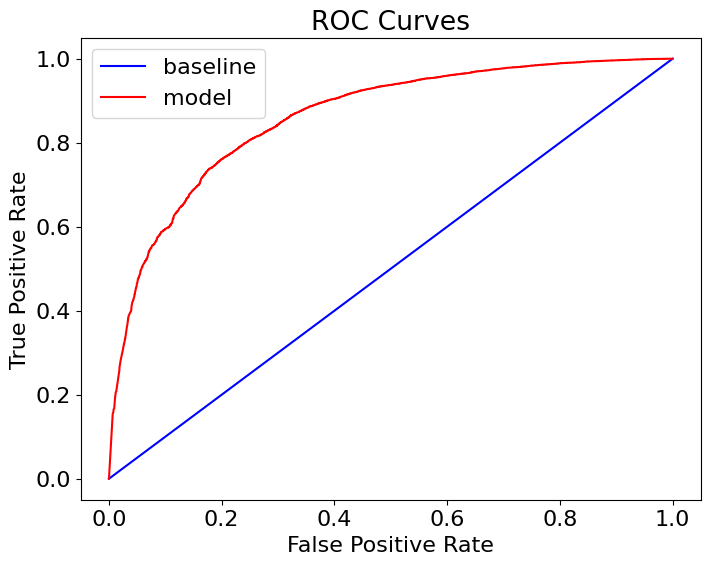

In [39]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)